In [95]:
# imports
from pathlib import Path
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily

/tmp/ipykernel_223132/1076012942.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  year: frontline.clip(focus_region.unary_union) for year, frontline in frontlines.items()
/tmp/ipykernel_223132/1076012942.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  year: frontline.clip(focus_region.unary_union) for year, frontline in frontlines.items()
/tmp/ipykernel_223132/1076012942.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  year: frontline.clip(focus_region.unary_union) for year, frontline in frontlines.items()
/tmp/ipykernel_223132/1076012942.py:41: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(title="Year", loc="upper left", fontsize=10)
/tmp/ipykernel_223

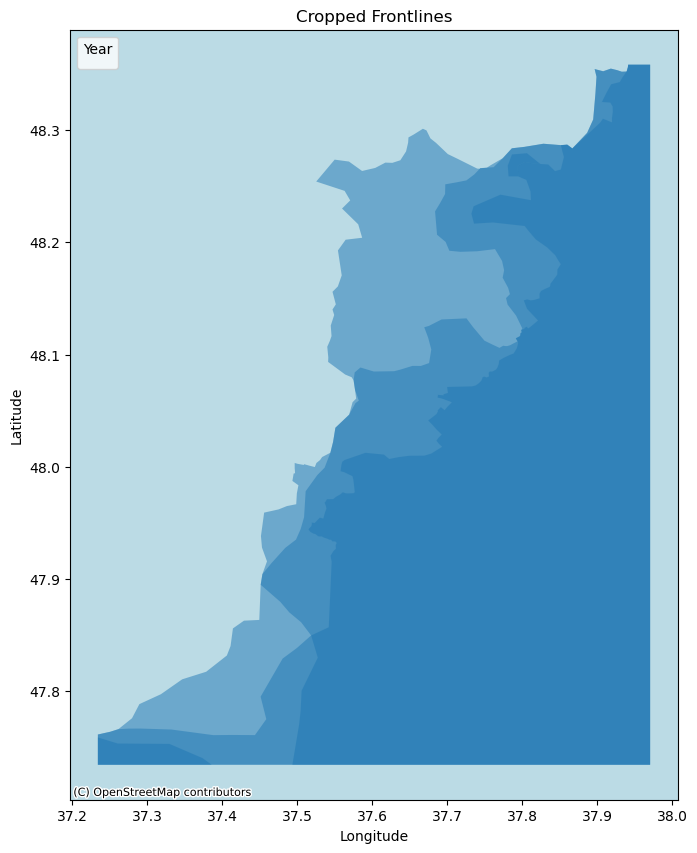

In [121]:
# get script dir
root = Path("")

# load frontline geojson shapes for each year
frontlines = {
    "2022": gpd.read_file(root / "data/source/nzz-maps/2022-06-01.json").to_crs("EPSG:4326"),
    "2023": gpd.read_file(root / "data/source/nzz-maps/2023-06-01.json").to_crs("EPSG:4326"),
    "2024": gpd.read_file(root / "data/source/nzz-maps/2024-06-01-adjusted.json").to_crs("EPSG:4326"),
}


# convert the adjusted frontline to a Polygon
frontlines["2024"] = frontlines["2024"].explode().reset_index(drop=True)

# Load the focus region shapefile
focus_region = gpd.read_file(root / "data/source/new_roi.json").to_crs("EPSG:4326")

# Get the bounds of the focus region
focus_bounds = focus_region.total_bounds

# Crop the frontlines to the focus region
frontlines_cropped = {
    year: frontline.clip(focus_region.unary_union) for year, frontline in frontlines.items()
}

# Plot cropped frontlines in reverse order
fig, ax = plt.subplots(figsize=(10, 10))
for year, frontline in reversed(frontlines_cropped.items()):
    if not frontline.empty:
        frontline = frontline.explode().reset_index(drop=True)
        frontline = frontline.to_crs(focus_region.crs)
        frontline.plot(ax=ax, label=f"{year} (cropped)", alpha=0.5)

# Plot the basemap using OpenStreetMap
contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik, zoom=9, alpha=0.8)

# Add title, labels, and legend
ax.set_title("Cropped Frontlines")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(title="Year", loc="upper left", fontsize=10)

plt.show()


In [101]:
# define subregions for each temporal frontline region
yearlist = ["2022", "2023", "2024"]
subregions = {}

# iterate over the years and create subregions
for year in yearlist:
	# get the unconquered part of the frontline (all the focus region that is not conquered)
	unconquered = focus_region.difference(frontlines_cropped[year])
	# get the conquered part of the frontline
	conquered = frontlines_cropped[year].intersection(focus_region)
	# get the held part of the frontline from the previous year
	if year == "2022":
		held = focus_region.union(frontlines_cropped[year])
	else:
		held = frontlines_cropped[str(int(year) - 1)].intersection(focus_region)
	# store the subregions in a dictionary
	subregions[year] = {
		"unconquered": unconquered,
		"conquered": conquered,
		"held": held,
	}
	print(f"Subregions for {year} created.")
	print(f"Unconquered: {unconquered}")
	print(f"Conquered: {conquered}")
	print(f"Held: {held}")


Subregions for 2022 created.
Unconquered: 0    POLYGON ((37.94118 48.35815, 37.94077 48.35579...
1                                                 None
2                                                 None
dtype: geometry
Conquered: 0    POLYGON ((37.55273 47.93202, 37.55156 47.93321...
1                                                 None
2                                                 None
dtype: geometry
Held: 0    POLYGON ((37.94118 48.35815, 37.9704 48.35815,...
1                                                 None
2                                                 None
dtype: geometry
Subregions for 2023 created.
Unconquered: 0    POLYGON ((37.94118 48.35815, 37.94077 48.35579...
dtype: geometry
Conquered: 0    POLYGON ((37.26181 47.76621, 37.27566 47.76672...
dtype: geometry
Held: 0    POLYGON ((37.55273 47.93202, 37.55156 47.93321...
1                                                 None
2                                                 None
dtype: geometry
Subregions for 2

/tmp/ipykernel_223132/1123316919.py:8: UserWarning: The indices of the left and right GeoSeries' are not equal, and therefore they will be aligned (reordering and/or introducing missing values) before executing the operation. If this alignment is the desired behaviour, you can silence this warning by passing 'align=True'. If you don't want alignment and protect yourself of accidentally aligning, you can pass 'align=False'.
  unconquered = focus_region.difference(frontlines_cropped[year])
/tmp/ipykernel_223132/1123316919.py:10: UserWarning: The indices of the left and right GeoSeries' are not equal, and therefore they will be aligned (reordering and/or introducing missing values) before executing the operation. If this alignment is the desired behaviour, you can silence this warning by passing 'align=True'. If you don't want alignment and protect yourself of accidentally aligning, you can pass 'align=False'.
  conquered = frontlines_cropped[year].intersection(focus_region)
/tmp/ipykerne

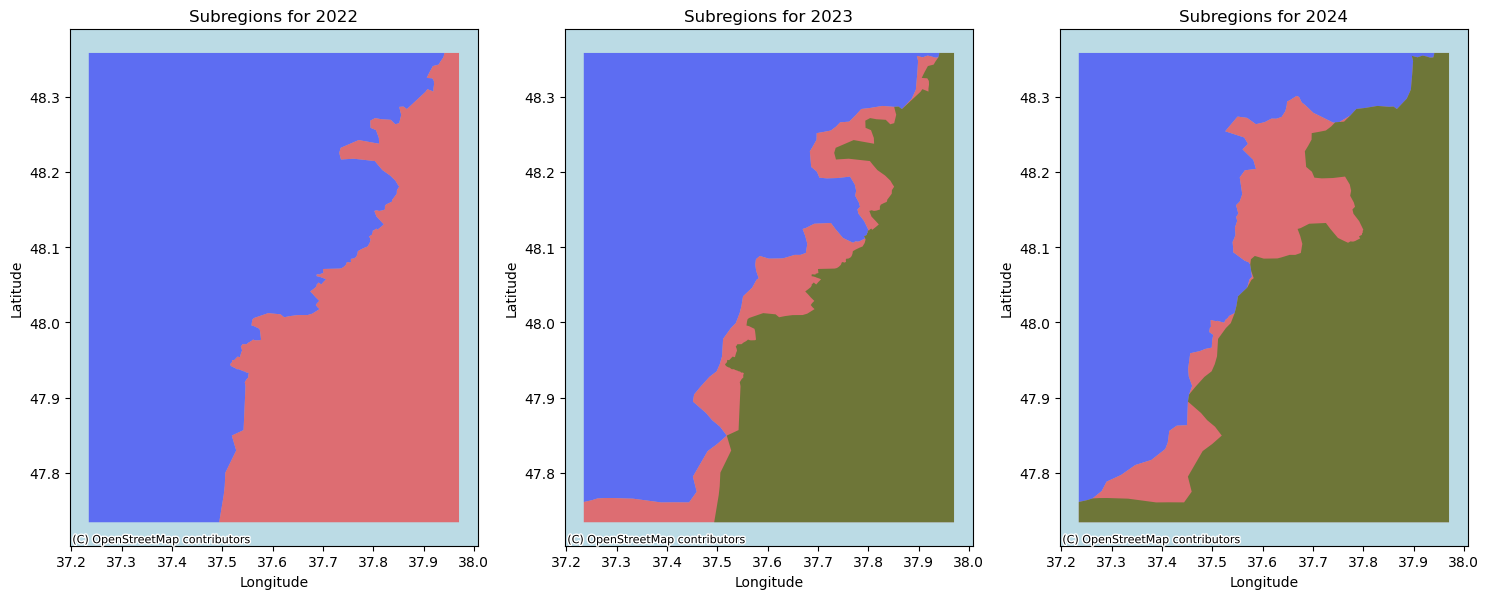

In [ ]:
# Plot the subregions in a 3x1 grid (One part for each year)
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
for i, (year, regions) in enumerate(subregions.items()):
	ax = axs[i]
	# set region type for legend

	# Plot the unconquered region
	if regions["unconquered"] is not None:
		regions["unconquered"].plot(ax=ax, color="blue", alpha=0.5, label="Unconquered")

	# Plot the conquered region
	if regions["conquered"] is not None:
		regions["conquered"].plot(ax=ax, color="red", alpha=0.5, label="Conquered")

	# Plot the held region
	if regions["held"] is not None:
		if year != "2022":
			regions["held"].plot(ax=ax, color="green", alpha=0.5, label="Held")

	# Plot the basemap using OpenStreetMap
	contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik, zoom=9, alpha=0.8)

	# Add title and labels
	ax.set_title(f"Subregions for {year}")
	ax.set_xlabel("Longitude")
	ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()


In [103]:
# Make sure the output directory exists
output_dir = root / "data/output/subregions"
output_dir.mkdir(parents=True, exist_ok=True)

# Save the subregions to GeoJSON files
for year, regions in subregions.items():
	for region_type, region in regions.items():
		if region is not None:
			# Save each region to a separate GeoJSON file
			output_path = root / f"data/output/subregions/{year}_{region_type}.geojson"
			region.to_file(output_path, driver="GeoJSON")
			print(f"Saved {region_type} for {year} to {output_path}")

Saved unconquered for 2022 to data/output/subregions/2022_unconquered.geojson
Saved conquered for 2022 to data/output/subregions/2022_conquered.geojson
Saved held for 2022 to data/output/subregions/2022_held.geojson
Saved unconquered for 2023 to data/output/subregions/2023_unconquered.geojson
Saved conquered for 2023 to data/output/subregions/2023_conquered.geojson
Saved held for 2023 to data/output/subregions/2023_held.geojson
Saved unconquered for 2024 to data/output/subregions/2024_unconquered.geojson
Saved conquered for 2024 to data/output/subregions/2024_conquered.geojson
Saved held for 2024 to data/output/subregions/2024_held.geojson


In [ ]:
# load spectral match data for custom combinations
spectral_dict = root / "data/output/spectral_match"
subregions_dict = root / "data/output/subregions"

custom_combinations = {
	"2022": {
		"spectral_match": spectral_dict / "S2_2022_2_summer_output.tif",
		"unconquered": subregions_dict / "2022_unconquered.geojson",
		"conquered": subregions_dict / "2022_conquered.geojson",
		"held": subregions_dict / "2022_held.geojson",
		},
	"2023": {
		"spectral_match": spectral_dict / "S2_2023_2_summer_output.tif",
		"unconquered": subregions_dict / "2023_unconquered.geojson",
		"conquered": subregions_dict / "2023_conquered.geojson",
		"held": subregions_dict / "2023_held.geojson",
		},
	"2024": {
		"spectral_match": spectral_dict / "S2_2024_2_summer_output.tif",
		"unconquered": subregions_dict / "2024_unconquered.geojson",
		"conquered": subregions_dict / "2024_conquered.geojson",
		"held": subregions_dict / "2024_held.geojson",
		},
}

# assert that all files exist
for year, paths in custom_combinations.items():
    for key, path in paths.items():
        if not path.exists():
            print(f"Missing file for {year}: {key} - {path}")
        else:
            print(f"File exists for {year}: {key} - {path}")

# Import necessary modules
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping
import os

# load the spectral match data and split it into the three regions
for year, paths in custom_combinations.items():
    print(f"Processing year {year}...")
    
    # load the spectral match data
    with rasterio.open(paths["spectral_match"]) as spectral_match:
        spectral_data = spectral_match.read(1)
        
        # Get metadata from the original raster for output files
        meta = spectral_match.meta.copy()
        
        # Process each region separately
        for region_name, region_path in [
            ("unconquered", paths["unconquered"]),
            ("conquered", paths["conquered"]),
            ("held", paths["held"])
        ]:
            print(f"  Processing {region_name} region...")
            
            # Read the region shapefile
            region_gdf = gpd.read_file(region_path)
            
            # Filter out null geometries and check if any valid geometries remain
            region_gdf = region_gdf[~region_gdf.geometry.isna()]
            
            if len(region_gdf) == 0:
                print(f"    WARNING: No valid geometries found in {region_name} region")
                # Create an empty raster with the same properties as the original
                out_path = f"{region_name}_region_{year}.tif"
                empty_data = np.zeros_like(spectral_data)
                with rasterio.open(out_path, 'w', **meta) as dst:
                    dst.write(empty_data, 1)
                print(f"    Created empty raster: {out_path}")
                continue
            
            # Make sure the CRS matches the raster
            if region_gdf.crs != spectral_match.crs:
                print(f"    Reprojecting {region_name} from {region_gdf.crs} to {spectral_match.crs}")
                region_gdf = region_gdf.to_crs(spectral_match.crs)
            
            try:
                # Convert geometries to GeoJSON format, skipping any None values
                geometries = []
                for geom in region_gdf.geometry:
                    if geom is not None:
                        geometries.append(mapping(geom))
                
                if not geometries:
                    raise ValueError("No valid geometries after filtering")
                
                # Create masked data using rasterio's mask function
                masked_data, masked_transform = mask(
                    spectral_match, 
                    geometries, 
                    crop=True, 
                    filled=True,
                    nodata=0
                )
                
                # Prepare output metadata with the new transform
                out_meta = meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": masked_data.shape[1],
                    "width": masked_data.shape[2],
                    "transform": masked_transform,
                    "nodata": 0
                })
                
                # Save the masked raster (unless it's 2022 held)
                if region_name == "held" and year == "2022":
                    print(f"    Skipping held region for {year}")
                    continue

                # Create the output directory if it doesn't exist
                out_dir = root / "data/output/subregions/rendered"
                out_dir.mkdir(parents=True, exist_ok=True)
                out_path = root / f"data/output/subregions/rendered/{region_name}_region_{year}.tif"
                with rasterio.open(out_path, 'w', **out_meta) as dst:
                    dst.write(masked_data)
                
                print(f"    Created: {out_path}")
                
            except Exception as e:
                print(f"    Error processing {region_name}: {e}")
                # Create a simple binary mask based on points in the region
                try:
                    print(f"    Attempting alternative method for {region_name}...")
                    
                    # Create a copy of the original data
                    out_data = np.zeros_like(spectral_data)
                    
                    # Create a binary mask for the region
                    mask_data = np.zeros_like(spectral_data, dtype=bool)
                    
                    # Use the bounds of the geometries to define a rough mask area
                    bounds = region_gdf.total_bounds
                    rows, cols = rasterio.transform.rowcol(
                        spectral_match.transform, 
                        [bounds[0], bounds[2]], 
                        [bounds[1], bounds[3]]
                    )
                    
                    # Set bounds for the mask (with bounds checking)
                    min_row = max(0, min(rows))
                    max_row = min(spectral_data.shape[0], max(rows))
                    min_col = max(0, min(cols))
                    max_col = min(spectral_data.shape[1], max(cols))
                    
                    # Create a simple mask based on the bounds
                    mask_data[min_row:max_row, min_col:max_col] = True
                    
                    # Apply the mask to the original data
                    out_data = np.where(mask_data, spectral_data, 0)
                    
                    # Save the output raster
                    out_path = f"{region_name}_region_{year}_simple.tif"
                    with rasterio.open(out_path, 'w', **meta) as dst:
                        dst.write(out_data, 1)
                    
                    print(f"    Created simple masked raster: {out_path}")
                    
                except Exception as alt_e:
                    print(f"    Alternative method also failed: {alt_e}")
                    # Last resort: create an empty raster
                    out_path = f"{region_name}_region_{year}_empty.tif"
                    empty_data = np.zeros_like(spectral_data)
                    with rasterio.open(out_path, 'w', **meta) as dst:
                        dst.write(empty_data, 1)
                    print(f"    Created empty raster as last resort: {out_path}")

    print(f"Completed processing for year {year}")

File exists for 2022: spectral_match - data/output/spectral_match/S2_2022_2_summer_output.tif
File exists for 2022: unconquered - data/output/subregions/2022_unconquered.geojson
File exists for 2022: conquered - data/output/subregions/2022_conquered.geojson
File exists for 2022: held - data/output/subregions/2022_held.geojson
File exists for 2023: spectral_match - data/output/spectral_match/S2_2023_2_summer_output.tif
File exists for 2023: unconquered - data/output/subregions/2023_unconquered.geojson
File exists for 2023: conquered - data/output/subregions/2023_conquered.geojson
File exists for 2023: held - data/output/subregions/2023_held.geojson
File exists for 2024: spectral_match - data/output/spectral_match/S2_2024_2_summer_output.tif
File exists for 2024: unconquered - data/output/subregions/2024_unconquered.geojson
File exists for 2024: conquered - data/output/subregions/2024_conquered.geojson
File exists for 2024: held - data/output/subregions/2024_held.geojson
Processing year 

In [115]:
# load all tifs
subregions_dict = root / "data/output/subregions/rendered"
subregions_tifs = {
	"2022": {
		"unconquered": subregions_dict / "unconquered_region_2022.tif",
		"conquered": subregions_dict / "conquered_region_2022.tif",
		"held": subregions_dict / "held_region_2022.tif",
	},
	"2023": {
		"unconquered": subregions_dict / "unconquered_region_2023.tif",
		"conquered": subregions_dict / "conquered_region_2023.tif",
		"held": subregions_dict / "held_region_2023.tif",
	},
	"2024": {
		"unconquered": subregions_dict / "unconquered_region_2024.tif",
		"conquered": subregions_dict / "conquered_region_2024.tif",
		"held": subregions_dict / "held_region_2024.tif",
	},
}

# get statistics for each region
def get_statistics(tif_path):
	with rasterio.open(tif_path) as src:
		data = src.read(1)
		# Calculate statistics
		mean = np.nanmean(data)
		median = np.nanmedian(data)
		std = np.nanstd(data)
		min_val = np.nanmin(data)
		max_val = np.nanmax(data)
	return mean, median, std, min_val, max_val

# create a dataframe to store the statistics
statistics_df = pd.DataFrame(columns=["Year", "Region", "Mean", "Median", "Std", "Min", "Max"])
# iterate over the tifs and get the statistics
for year, regions in subregions_tifs.items():
	for region_name, tif_path in regions.items():
		if year == "2022" and region_name == "held":
			print(f"Skipping held region for {year}")
			continue
		print(f"Processing {year} {region_name}...")
		mean, median, std, min_val, max_val = get_statistics(tif_path)
		# Append the statistics to the dataframe using pd.concat
		new_row = pd.DataFrame([{
			"Year": year,
			"Region": region_name,
			"Mean": mean,
			"Median": median,
			"Std": std,
			"Min": min_val,
			"Max": max_val
		}])
		statistics_df = pd.concat([statistics_df, new_row], ignore_index=True)

# Save the statistics to a CSV file
output_csv_path = root / "data/output/subregions/statistics.csv"
statistics_df.to_csv(output_csv_path, index=False)
print(f"Statistics saved to {output_csv_path}")
# Print the statistics dataframe
print(statistics_df)

Processing 2022 unconquered...
Processing 2022 conquered...
Skipping held region for 2022
Processing 2023 unconquered...
Processing 2023 conquered...
Processing 2023 held...
Processing 2024 unconquered...
Processing 2024 conquered...
Processing 2024 held...
Statistics saved to data/output/subregions/statistics.csv
   Year       Region      Mean  Median       Std  Min       Max
0  2022  unconquered  0.391702     0.0  0.534038  0.0  3.586517
1  2022    conquered  0.238964     0.0  0.439368  0.0  3.378095
2  2023  unconquered  0.284609     0.0  0.494144  0.0  3.455416
3  2023    conquered  0.251506     0.0  0.476245  0.0  3.630976
4  2023         held  0.289008     0.0  0.490110  0.0  3.630976
5  2024  unconquered  0.219050     0.0  0.425990  0.0  3.341894
6  2024    conquered  0.320489     0.0  0.480121  0.0  3.272920
7  2024         held  0.268592     0.0  0.458955  0.0  3.272920


/tmp/ipykernel_223132/1125118317.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  statistics_df = pd.concat([statistics_df, new_row], ignore_index=True)


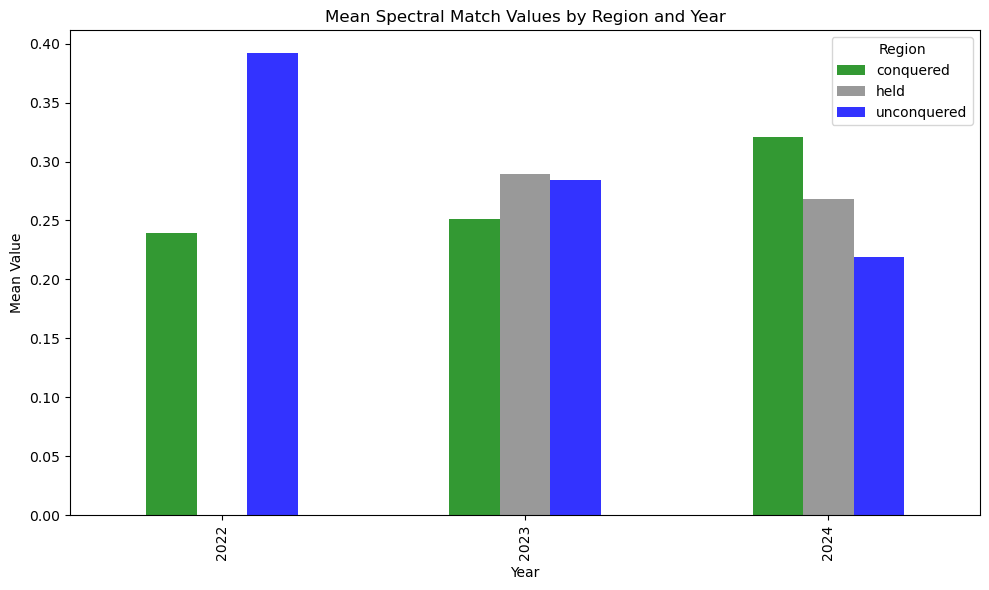

In [125]:
# Prepare data for the bar plot
bar_data = statistics_df.pivot(index="Year", columns="Region", values="Mean").fillna(0)

# Plot the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_data.plot(kind="bar", ax=ax, color=["green", "gray", "blue"], alpha=0.8)

# Set the title and labels
ax.set_title("Mean Spectral Match Values by Region and Year")
ax.set_xlabel("Year")
ax.set_ylabel("Mean Value")
ax.legend(title="Region")
plt.tight_layout()
plt.show()


Processing 2022 unconquered...
  Pixels: (5404/547752) at threshold 2 - percentage: 0.99%
Processing 2022 conquered...
  Pixels: (1738/370272) at threshold 2 - percentage: 0.47%
Skipping held region for 2022
Processing 2023 unconquered...
  Pixels: (4761/524142) at threshold 2 - percentage: 0.91%
Processing 2023 conquered...
  Pixels: (4664/570720) at threshold 2 - percentage: 0.82%
Processing 2023 held...
  Pixels: (3185/370272) at threshold 2 - percentage: 0.86%
Processing 2024 unconquered...
  Pixels: (1801/524142) at threshold 2 - percentage: 0.34%
Processing 2024 conquered...
  Pixels: (2942/570720) at threshold 2 - percentage: 0.52%
Processing 2024 held...
  Pixels: (2606/570720) at threshold 2 - percentage: 0.46%


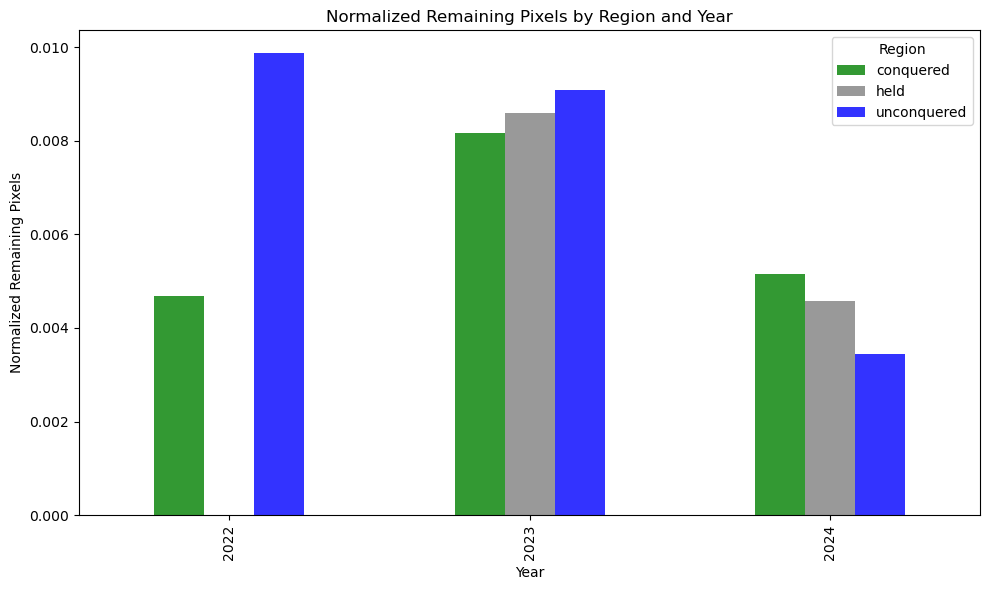

In [133]:
# load all tifs
subregions_dict = root / "data/output/subregions/rendered"
subregions_tifs = {
	"2022": {
		"unconquered": subregions_dict / "unconquered_region_2022.tif",
		"conquered": subregions_dict / "conquered_region_2022.tif",
		"held": subregions_dict / "held_region_2022.tif",
	},
	"2023": {
		"unconquered": subregions_dict / "unconquered_region_2023.tif",
		"conquered": subregions_dict / "conquered_region_2023.tif",
		"held": subregions_dict / "held_region_2023.tif",
	},
	"2024": {
		"unconquered": subregions_dict / "unconquered_region_2024.tif",
		"conquered": subregions_dict / "conquered_region_2024.tif",
		"held": subregions_dict / "held_region_2024.tif",
	},
}

# keep only values above a certain threshold 
threshold = 2

def process_tif(tif_path, threshold):
	with rasterio.open(tif_path) as src:
		data = src.read(1)
		total_pixels = data.size
		# Apply the threshold
		data[data < threshold] = 0
		remaining_pixels = np.count_nonzero(data)
		return total_pixels, remaining_pixels, data
	
# create a dataframe to store the statistics
statistics_df = pd.DataFrame(columns=["Year", "Region", "Total Pixels", "Remaining Pixels"])
# iterate over the tifs and get the statistics
for year, regions in subregions_tifs.items():
	for region_name, tif_path in regions.items():
		if year == "2022" and region_name == "held":
			print(f"Skipping held region for {year}")
			continue
		print(f"Processing {year} {region_name}...")
		total_pixels, remaining_pixels, data = process_tif(tif_path, threshold)
		# Append the statistics to the dataframe using pd.concat
		new_row = pd.DataFrame([{
			"Year": year,
			"Region": region_name,
			"Total Pixels": total_pixels,
			"Remaining Pixels": remaining_pixels,
			"Normalized Remaining Pixels": remaining_pixels / total_pixels
		}])
		print(f"  Pixels: ({remaining_pixels}/{total_pixels}) at threshold {threshold} - percentage: {remaining_pixels / total_pixels:.2%}")
		statistics_df = pd.concat([statistics_df, new_row], ignore_index=True)

# Plot the normalized remaining pixels
fig, ax = plt.subplots(figsize=(10, 6))
# Prepare data for the bar plot
bar_data = statistics_df.pivot(index="Year", columns="Region", values="Normalized Remaining Pixels").fillna(0)
bar_data.plot(kind="bar", ax=ax, color=["green", "gray", "blue"], alpha=0.8)
# Set the title and labels
ax.set_title("Normalized Remaining Pixels by Region and Year")
ax.set_xlabel("Year")
ax.set_ylabel("Normalized Remaining Pixels")
ax.legend(title="Region")
plt.tight_layout()
plt.show()
